<a href="https://colab.research.google.com/github/fatima-bukhari5/liveness_detection_colab/blob/main/Liveness_VGG16_Copy1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Library Imports

In [1]:
# Reference section to call important lib.

# mathemathical & data manupulation
import numpy as np          # numpy for mathemathical operations
import pandas as pd         # to manage data in two dimension structures

# O/S, command line, serialization, deserialization, iterations
import argparse             # command line arguments management.
import pickle               # pickle for object serialization/de-serialization
import os                   # to interact with operating system
import itertools            # to enhance iteration over object, i.e. for loop

# image processing
import cv2                  # opencv for image pre-processing
from imutils import paths   # another convienance for image processing like opencv

# For Data visualization & charts
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# Reference to Scikit Learn for data pre-processing & post training
# performance evaluation. 
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# Reference to keras with tensorflow engine for model training.
import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Activation
from keras.models import Model
from keras.layers.core import Dense, Flatten
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import BatchNormalization
from keras.layers.convolutional import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers


### Importing Data Sets

In [2]:
INIT_LR = 0.0001  # a variable for learning rate parameter while training
BS = 10           # ??????
EPOCHS = 16        # a variable for number of epochs parameter while training model

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# location for training, validation & testing dataset 
train_path = '/content/drive/MyDrive/real_and_fake/train'
valid_path = '/content/drive/MyDrive/real_and_fake/valid'
test_path = '/content/drive/MyDrive/real_and_fake/test'

In [25]:
def read_image_data(X,Y, height, width):
    '''
    The following function is to convert the data into numpy array through
    `data_processing` function and resize it according vgg16 input size 
    of 224 by 224.
    
    Requirement:  Convert input images to heightxwidth for VGG16
    Usage:        Pre-Processing.
    Functionality:
                  1. load images one by one from folder, resize & attach lable.
                  2. Convert image to numpy array & return array with lable. 
    Parameters:
                  X => df['Image paths'] (dataframe column of image paths)
                  Y => df['Labels'] (dataframe column of image labels)

    Returns:      `image` in the form of numpy array & labels as encoded.
    '''
    # to do: variables & parmeters naming convention.
    # declaration Section
    data =[]                                      # An array to hold images.
    labels = Y                                    # A variable to hold label from parameter.
    # execution section    
    # to do: exception handling
    for path in X:                                # for each image in a given folder.
        image = cv2.imread(path)                  # reading image from given path.
        image = cv2.resize(image,(height,width))       # resizing image as of input requirement.
        data.append(image)                        # add image to declared array structure.
    data, labels = data_processing(data, labels)  # Calling & passing parameters to data_processing function.
    # to do: use python log api for console message, if any. print is childish.
    print('[INFO] Converting Data into Image form and encoding labels')
    # return section
    return data, labels

In [6]:
def data_organization(img_path):
    '''
    This function is to organize the data in the form of data frames to have clear understanding 
    and readability of data w.r.t to its labels

    Parameters: 
    img_path = folder path of images base folder as string

    Returns: dataframe with organized image paths and their labels
    '''
    print("Getting labels for images...")
    data = []
    labels = []
    list_image_path = []
    folders_list = os.listdir(img_path)
    
    # loop over all folders at a time. i.e real and fake
    for folder in folders_list:
        
        # extract the class label from the filename to add into the df
    
        folder_path = os.path.join(img_path,folder)
        images_list = os.listdir(folder_path)
        for image_name in images_list:
            label = folder
            imagePath = os.path.join(folder_path,image_name)
            labels.append(label)
            list_image_path.append(imagePath)
            
    image_path_label = {'image_path': list_image_path,'labels':labels}
    df_image_path_label = pd.DataFrame(image_path_label)
    
    print("DataFrame Complete....")
    return df_image_path_label

In [7]:
def data_processing(data,labels):
    '''
    Data processing to convert images data to numpy along with label encoding
    
    Parameters:
    data -> list of images data
    labels -> list of labels
    
    returns:
    data, labels as numpy array of image data and encoded labels
    '''
    data = np.array(data, dtype="float")
    le = LabelEncoder()
    labels = le.fit_transform(labels)
    labels = to_categorical(labels, 2)
    
    return data, labels

## Build Fine-tuned VGG16 model

VGG16 Model was used in an ImageNet competition where thousands of images were classified into different categories. We'll be using this model as a baseline and fine tune it as to our specific requirements. 
VGG16 in itself is a model that classifies images into a number of classes that are not limited to just two. In our case the output layer requires just two nodes representing two classes as `real` and `fake`. So, we will be tuning the model accordingly. 
<br>
<br>

Importing the model will take time as its a file of size almost 17 MB 

In [8]:
def model_training(train_data, train_labels, val_data, val_labels):
    '''
    The function is involved with 
        - data augmentation 
        - sequential model initialization
        - using vgg16 model layers as base layers for the new model.
        - compiling the model
        - training the model
    
    returns a trained model file
    '''
    # construct the training image generator for data augmentation
    aug = ImageDataGenerator(rotation_range=20, zoom_range=0.15,
        width_shift_range=0.2, height_shift_range=0.2, shear_range=0.15,
        horizontal_flip=True, fill_mode="nearest")
   
    print("[INFO] importing VGG16 ")
    vgg16_model = keras.applications.vgg16.VGG16(include_top=True)
    
    # getting a sequential model and freezing the previous
    model = Sequential()
    for layer in vgg16_model.layers[:-1]:
        model.add(layer)
    
    # After poping the last layer, freeze the previous layers and adding a new dense output layer
    for layer in model.layers:
        layer.trainable = False
    model.add(Dense(2, activation='softmax'))
    
    # initialize the optimizer and model
    print("[INFO] compiling model...")
    opt = Adam(lr=INIT_LR)
    
    model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])
    
    # train the network
    print("[INFO] training network for {} epochs...".format(EPOCHS))
    
    model.fit(x=aug.flow(train_data, train_labels, batch_size=BS),
        validation_data=(val_data, val_labels), validation_steps=5, steps_per_epoch=len(train_data) / BS,
        epochs=EPOCHS)
    
    return model

In [20]:
def get_predictions(model, df_testing, height, width):
    '''
    Getting predictions w.r.t to the trained model as passed and the training data
    
    Parameters:
    model: trained model
    df_testing: data for testing in the form of dataframe
    
    Returns:
    
    Predictions as 0 or 1 and true_labels after data processing
    '''
    
    # getting test data in numpy 
    test_data, true_labels = read_image_data(df_testing['image_path'], df_testing['labels'], height, width) 
    
    # gettin predictions against the model
    print('[INFO] Getting Predictions')
    predictions = model.predict(test_data, steps=1, verbose=0)
    predictions_rounded = np.round(predictions)
    
    return predictions_rounded, true_labels

In [10]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [11]:
def model_performance(predictions, true_labels):
    '''
    The model displays a confusion matrix using a previously built confusion matrix function taken from sklearn.
    
    Parameters:
    predictions: previous predictions
    true_labels: array of actual labels to be compared
    
    Result: dislay confusion matrix
    '''
    print('[INFO] Getting Confusion Matrix')
    cm = confusion_matrix(true_labels[:,0], predictions[:,0])
    

    cm_plot_labels = ['real','fake']
    plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')
    

In [27]:
def main_vgg16():
    '''
    calling all functions
    '''
    
    # getting labels to each data set
    df_training = data_organization(train_path)
    df_validation = data_organization(valid_path)
    df_testing = data_organization(test_path)
    
    # getting train and validation data in numpy 
    train_data, train_labels = read_image_data(df_training['image_path'], df_training['labels'],224, 224)
    val_data, val_labels = read_image_data(df_validation['image_path'], df_validation['labels'], 224, 224)
    
    # get the trained model
    model = model_training(train_data=train_data, train_labels=train_labels, 
                           val_data=val_data, val_labels=val_labels)
    
    # get the results
    predictions, true_labels = get_predictions(model = model, df_testing=df_testing, height = 224, width = 224)
    
    #
    model_performance(predictions=predictions, true_labels=true_labels)

Getting labels for images...
DataFrame Complete....
Getting labels for images...
DataFrame Complete....
Getting labels for images...
DataFrame Complete....
[INFO] Converting Data into Image form and encoding labels
[INFO] Converting Data into Image form and encoding labels
[INFO] importing VGG16 
[INFO] compiling model...
[INFO] training network for 16 epochs...


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/16
30/30 [==============================] - 5s 153ms/step - loss: 0.9541 - accuracy: 0.5067 - val_loss: 0.6600 - val_accuracy: 0.7100
Epoch 2/16
30/30 [==============================] - 5s 167ms/step - loss: 0.6829 - accuracy: 0.6800 - val_loss: 0.4842 - val_accuracy: 0.8100
Epoch 3/16
30/30 [==============================] - 4s 146ms/step - loss: 0.6026 - accuracy: 0.7000 - val_loss: 0.3731 - val_accuracy: 0.8800
Epoch 4/16
30/30 [==============================] - 5s 166ms/step - loss: 0.5584 - accuracy: 0.7600 - val_loss: 0.3274 - val_accuracy: 0.9000
Epoch 5/16
30/30 [==============================] - 4s 146ms/step - loss: 0.5060 - accuracy: 0.8033 - val_loss: 0.3028 - val_accuracy: 0.8700
Epoch 6/16
30/30 [==============================] - 4s 146ms/step - loss: 0.5047 - accuracy: 0.7833 - val_loss: 0.2888 - val_accuracy: 0.8700
Epoch 7/16
30/30 [==============================] - 4s 144ms/step - loss: 0.4314 - accuracy: 0.8467 - val_loss: 0.2727 - val_accuracy: 0.8700
Epoch 

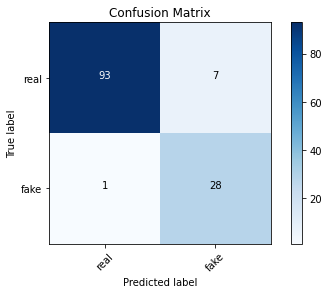

In [28]:
main_vgg16()

### Mobile Net

In [14]:
def model_training_mobile_net(train_data, train_labels, val_data, val_labels):
    '''
    The function is involved with 
        - data augmentation 
        - sequential model initialization
        - using mobile net model layers as base layers for the new model.
        - compiling the model
        - training the model
    
    returns a trained model file
    '''
    # construct the training image generator for data augmentation
    aug = ImageDataGenerator(rotation_range=20, zoom_range=0.15,
        width_shift_range=0.2, height_shift_range=0.2, shear_range=0.15,
        horizontal_flip=True, fill_mode="nearest")
   
    print("[INFO] importing mobile net ")
    mobile_net_model = keras.applications.mobilenet.MobileNet()
    
    # getting a sequential model and freezing the previous
    model = Sequential()
    for layer in mobile_net_model.layers[:-1]:
        model.add(layer)
    
    # After poping the last layer, freeze the previous layers and adding a new dense output layer
    for layer in model.layers:
        layer.trainable = False
    model.add(Dense(2, activation='softmax'))
    
    # initialize the optimizer and model
    print("[INFO] compiling model...")
    opt = Adam(lr=INIT_LR)
    
    model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])
    
    # train the network
    print("[INFO] training network for {} epochs...".format(EPOCHS))
    
    model.fit(x=aug.flow(train_data, train_labels, batch_size=BS),
        validation_data=(val_data, val_labels), validation_steps=5, steps_per_epoch=len(train_data) / BS,
        epochs=20)
    
    return model

In [15]:
def main_mobile_net():
  '''
  calling all functions
  '''
    
  # getting labels to each data set
  df_training = data_organization(train_path)
  df_validation = data_organization(valid_path)
  df_testing = data_organization(test_path)
    
  # getting train and validation data in numpy 
  train_data, train_labels = read_image_data(df_training['image_path'], df_training['labels'],224,224)
  val_data, val_labels = read_image_data(df_validation['image_path'], df_validation['labels'],224,224)
    
  # get the trained model
  model = model_training_mobile_net(train_data=train_data, train_labels=train_labels, 
                           val_data=val_data, val_labels=val_labels)
    
  # get the results
  predictions, true_labels = get_predictions(model = model, df_testing=df_testing, height = 224, width = 224)
    
  # get confusion matrix
  model_performance(predictions=predictions, true_labels=true_labels)


Getting labels for images...
DataFrame Complete....
Getting labels for images...
DataFrame Complete....
Getting labels for images...
DataFrame Complete....
[INFO] Converting Data into Image form and encoding labels
[INFO] Converting Data into Image form and encoding labels
[INFO] importing mobile net 
17235968/17225924 [==============================] - 0s 0us/step
[INFO] compiling model...
[INFO] training network for 16 epochs...
Epoch 1/20


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


30/30 [==============================] - 6s 137ms/step - loss: 0.9908 - accuracy: 0.5333 - val_loss: 0.7823 - val_accuracy: 0.6500
Epoch 2/20
30/30 [==============================] - 3s 111ms/step - loss: 0.8532 - accuracy: 0.5767 - val_loss: 0.7129 - val_accuracy: 0.6700
Epoch 3/20
30/30 [==============================] - 3s 113ms/step - loss: 0.9027 - accuracy: 0.5567 - val_loss: 0.6877 - val_accuracy: 0.6800
Epoch 4/20
30/30 [==============================] - 3s 111ms/step - loss: 0.8512 - accuracy: 0.5600 - val_loss: 0.6505 - val_accuracy: 0.6900
Epoch 5/20
30/30 [==============================] - 4s 117ms/step - loss: 0.8073 - accuracy: 0.5933 - val_loss: 0.6230 - val_accuracy: 0.7200
Epoch 6/20
30/30 [==============================] - 3s 112ms/step - loss: 0.8207 - accuracy: 0.5367 - val_loss: 0.6101 - val_accuracy: 0.7300
Epoch 7/20
30/30 [==============================] - 3s 111ms/step - loss: 0.7748 - accuracy: 0.6033 - val_loss: 0.5971 - val_accuracy: 0.7300
Epoch 8/20
30/30 

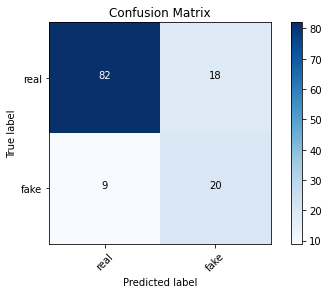

In [16]:
main_mobile_net()

# Multi Model Training



Models to be trained 


*   EfficientNetV2L - Size: 480x480
*   EfficientNetB7 - Size: 600x600
*   NASNetLarge - Size: 331x331
*   InceptionResNetV2 - Size: 299x299



In [32]:
eff_netv2l = keras.applications.efficientnet_v2.EfficientNetV2L(include_top=True)
eff_netb7 = keras.applications.efficientnet.EfficientNetB7(include_top=True)
nas_net_large = keras.applications.nasnet.NASNetLarge(include_top=True)
inc_resnetv2 = keras.applications.inception_resnet_v2.InceptionResNetV2(include_top=True)

In [31]:
eff_netv2l.summary()

Model: "efficientnetv2-l"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 480, 480, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 480, 480, 3)  0           ['input_3[0][0]']                
                                                                                                  
 stem_conv (Conv2D)             (None, 240, 240, 32  864         ['rescaling[0][0]']              
                                )                                                                 
                                                                                   

In [19]:
print(eff_netv2l.name)
print(eff_netb7.name)
print(nas_net_large.name)
print(inc_resnetv2.name)

efficientnetv2-l
efficientnetb7
NASNet
inception_resnet_v2


In [22]:
def model_training_multi_models(train_data, train_labels, val_data, val_labels, model_):
    '''
    The function is involved with 
        - data augmentation 
        - sequential model initialization
        - compiling the model
        - training the model
    
    returns a trained model file
    '''
    # construct the training image generator for data augmentation
    # 
    
    img_augmentation = Sequential(
    [
        layers.RandomRotation(factor=0.15),
        layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
        layers.RandomFlip(),
        layers.RandomContrast(factor=0.1),
    ],
    name="img_augmentation",)
    
    
    # getting a sequential model and freezing the previous
    model = Sequential()
    for layer in model_.layers[:-1]:
        model.add(layer)
    
    # After poping the last layer, freeze the previous layers and adding a new dense output layer
    for layer in model.layers:
        layer.trainable = False
    model.add(Dense(2, activation='softmax'))
    
    # initialize the optimizer and model
    print("[INFO] compiling model...")
    opt = Adam(lr=INIT_LR)
    
    model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])
    
    # train the network
    print("[INFO] training network for {} epochs...".format(EPOCHS))
    
    model.fit(x=aug.flow(train_data, train_labels, batch_size=BS),
        validation_data=(val_data, val_labels), validation_steps=5, steps_per_epoch=len(train_data) / BS,
        epochs=20)
    
    return model

In [33]:
def main_all_funcs():
  '''
  calling all functions
  '''
    
  # getting labels to each data set
  df_training = data_organization(train_path)
  df_validation = data_organization(valid_path)
  df_testing = data_organization(test_path)

  # get all model types
  eff_netv2l = keras.applications.efficientnet_v2.EfficientNetV2L(include_top=True)
  eff_netb7 = keras.applications.efficientnet.EfficientNetB7(include_top=True)
  nas_net_large = keras.applications.nasnet.NASNetLarge(include_top=True)
  inc_resnetv2 = keras.applications.inception_resnet_v2.InceptionResNetV2(include_top=True)

  # list of models
  all_models = [eff_netv2l,eff_netv2l,nas_net_large,inc_resnetv2]
  height = 0
  width = 0
  all_results = {}

  for model_ in all_models:
    if model_.name == "efficientnetv2-l":
      height = 480
      width = 480
    elif model_.name == "efficientnetb7":
      height = 600
      width = 600
    elif model_.name == "NASNet":
      height = 331
      width = 331
    elif model_.name == "inception_resnet_v2":
      height = 299
      width = 299

    # get resized data as per model
    train_data, train_labels = read_image_data(df_training['image_path'], df_training['labels'], height, width)
    val_data, val_labels = read_image_data(df_validation['image_path'], df_validation['labels'], height, width)

    # get trained model
    print("[INFO] Training model ", model_.name)
    model = model_training_multi_models(train_data=train_data, train_labels=train_labels, 
                           val_data=val_data, val_labels=val_labels, model_= model_)
      
    # get the results
    predictions, true_labels = get_predictions(model = model, df_testing=df_testing, height = height, width = width)

    all_results[str(model_.name)] = {
        "predictions": predictions,
        "true_labels": true_labels
        } 

  return all_results


In [34]:
all_results = main_all_funcs()

Getting labels for images...
DataFrame Complete....
Getting labels for images...
DataFrame Complete....
Getting labels for images...
DataFrame Complete....
[INFO] Converting Data into Image form and encoding labels
[INFO] Converting Data into Image form and encoding labels
[INFO] Training model  efficientnetv2-l


ValueError: ignored